# 06 · Clustering dinámico de estaciones

## Objective
xxx
1.  xxx
2.  xxx

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import os

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

## Load data

Load the distance matrices calculated in the previously. Note that we have two separate analyses: **Weekday** (Laboral) and **Weekend** (Ocio).

In [2]:
IMPUT_DIR = '../data/processed/clustering'

def load_clustering_data(day_type):
    """
    Loads the distance matrix, station IDs, and original signatures for a given day type 
    ('weekday' or 'weekend').
    """
    print(f"Loading data for: {day_type}")

    # Load matrix
    matrix_path = os.path.join(IMPUT_DIR, f'dtw_matrix_{day_type}.npy')
    dtw_matrix = np.load(matrix_path)

    # Load IDs
    ids_path = os.path.join(IMPUT_DIR, f'station_ids_{day_type}.npy')
    station_ids = np.load(ids_path)

    # Load original signatures
    sig_path = os.path.join(IMPUT_DIR, f'signatures_{day_type}.csv')
    df_signatures = pd.read_csv(sig_path, index_col=0)

    print(f"  Matrix Shape: {dtw_matrix.shape}")
    print(f"  Stations: {len(station_ids)}")
    
    return dtw_matrix, station_ids, df_signatures

dtw_matrix_weekday, station_ids_weekday, df_signatures_weekday = load_clustering_data('weekday')
dtw_matrix_weekend, station_ids_weekend, df_signatures_weekend = load_clustering_data('weekend')

Loading data for: weekday
  Matrix Shape: (2235, 2235)
  Stations: 2235
Loading data for: weekend
  Matrix Shape: (2234, 2234)
  Stations: 2234


## Weekday analysis

Primeramente se va a comenzar con el análisis de las estaciones entre semana. En este caso se busca encontrar estaciones cerca de viviendas donde los usuarios utilicen el servicio para ir a trabajar y estaciones donde se aparcan las bicicletas al llegar al trabajo. Igualmente se visualizará si existen más tipos.

### Dendrogram

To perform hierarchical clustering on a pre-computed distance matrix, we must convert it to a **condensed distance matrix** (upper triangular) and then calculate the **Linkage Matrix**.

* **Linkage Method:** We use `'average'` (UPGMA). It generally produces balanced clusters and is robust for DTW distances.

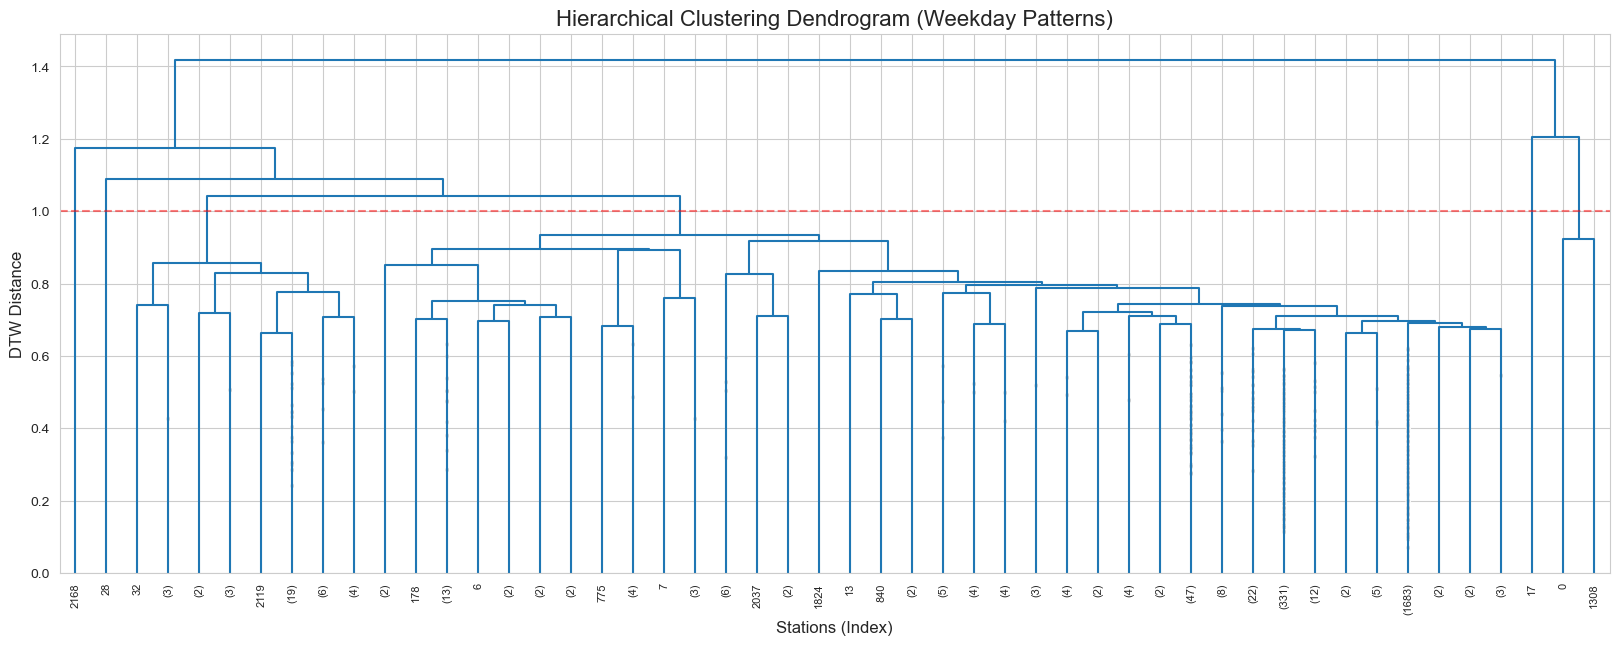

In [3]:
# Convert distance matrix to condensed form for hierarchical clustering
dist_condensed_weekday = squareform(dtw_matrix_weekday)

# Compute hierarchical clustering
Z_weekday = linkage(dist_condensed_weekday, method='average')

# Plot dendrogram
plt.figure(figsize=(20, 7))
plt.title('Hierarchical Clustering Dendrogram (Weekday Patterns)', fontsize=16)
plt.xlabel('Stations (Index)', fontsize=12)
plt.ylabel('DTW Distance', fontsize=12)

dendrogram(
    Z_weekday,
    leaf_rotation=90.,  
    leaf_font_size=8.,
    truncate_mode='lastp',
    p=50,
    show_contracted=True,
    color_threshold=0
)
plt.axhline(y=1, c='r', ls='--', alpha=0.5)
plt.show()

Viendo el dendrograma, existen tres posibilidades que tienen sentido en el caso de estudio del clustering de estaciones:
1. **Cortar por 1.15 (4 clusters):** Cortar a esta altura no sería mala opción, sin embargo parece demasiado generalista ya que probablemente acabaría agrupando estaciones que podrian estar separadas.
2. **Cortar por 0.85 (8 clusters):** En este caso pasa lo contrario, bajando el valor de corte un poco más acabarían por aparecer demasiados clusteres, lo que supondría la creación de divisiones "artificiales", creando más ruido que información real.
3. **Cortar por 1 (6 clusters):** Es el valor intermedio desde donde se encuentran grupos que sean los suficientemente distintos para ser útiles pero lo suficientemente grandes para ser generalizables. Este va a ser el valor que se va a utilizar para la división, utilizando **K = 6**.

In [4]:
# Number of clusters
K_weekday = 6

print(f"Cutting tree to obtain {K_weekday} clusters\n")

cluster_labels_weekday = fcluster(Z_weekday, t=K_weekday, criterion='maxclust')

df_signatures_weekday['cluster_label'] = cluster_labels_weekday

print("Distribution of stations per cluster:")
print(df_signatures_weekday['cluster_label'].value_counts().sort_index())

Cutting tree to obtain 6 clusters

Distribution of stations per cluster:
cluster_label
1      39
2    2191
3       1
4       1
5       2
6       1
Name: count, dtype: int64


Tras cortar utilizando **K = 6** se puede observar que hay estaciones "solitarias", correspondientes a los clusteres 3, 4, 5 y 6. Esto se debe porque son outliers extrenos, es decir, que son estaciones que se comportan de manera diferente a las demás, como estaciones de prueba, estaciones que estuvieron cerradas, que tuvieron muy pocos usos, etc. Al ser tan matemáticamente diferentes del resto, el algoritmo las separa primero, y como resultado el cluster 2 se ha convertido en un cluster que agrupa todas las estaciones normales ocultando las diferencias que existen entre ellas. 

Esto se puede deber por el `method:'average'` utilizado ya que es muy sensible con los outliers. Para intentar solucionar este problema, se utilizará el método **ward**. Ward en lugar de mirar las distancias, intenta minimizar la varianza dentro de cada grupo, forzando al algoritmo a crear grupos esféricos y más equilibrados en tamaño.

A continuación se volverá a repetir el experimento y a mostrar el dendrograma pero realizando el cambio de método para ver las diferencias.

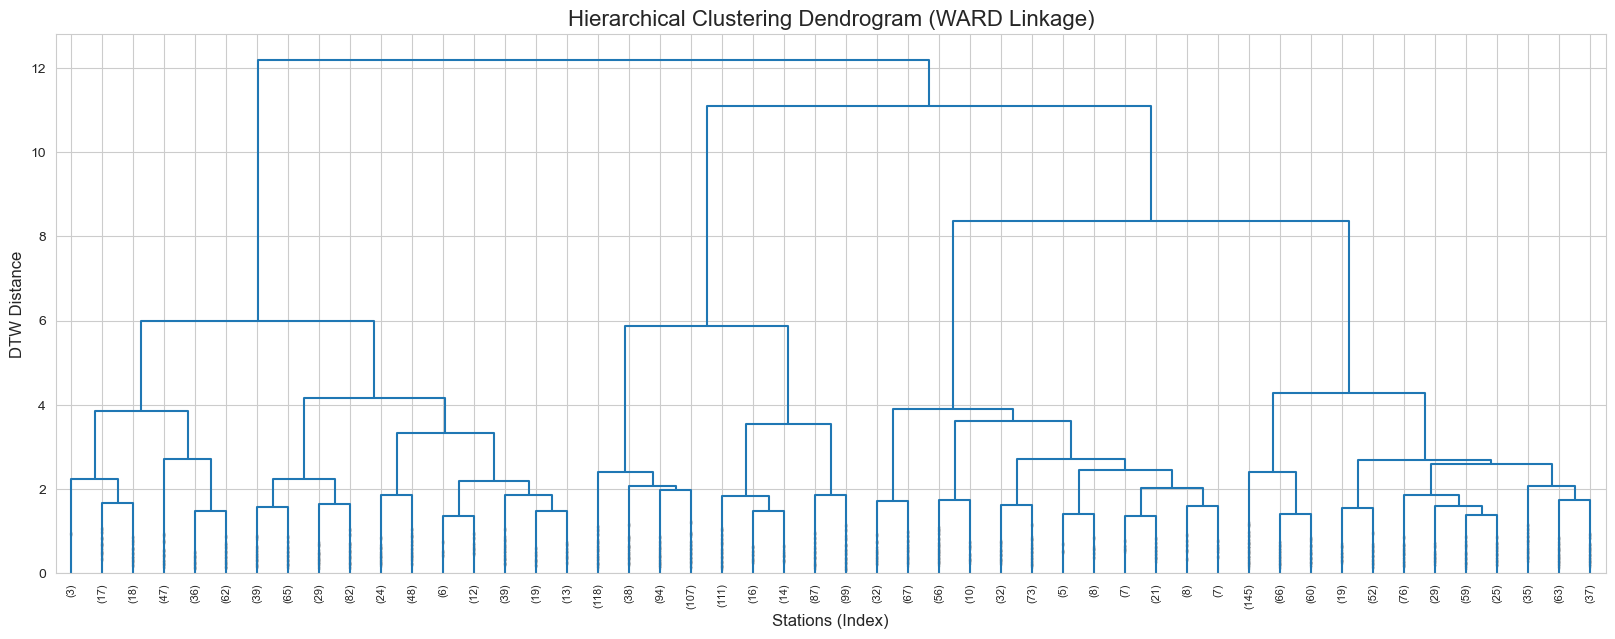

In [5]:
# Use 'ward' instead of 'average'
Z_weekday = linkage(dist_condensed_weekday, method='ward')

# Plot dendrogram
plt.figure(figsize=(20, 7))
plt.title('Hierarchical Clustering Dendrogram (WARD Linkage)', fontsize=16)
plt.xlabel('Stations (Index)', fontsize=12)
plt.ylabel('DTW Distance', fontsize=12)

dendrogram(
    Z_weekday,
    leaf_rotation=90.,  
    leaf_font_size=8.,
    truncate_mode='lastp',
    p=50,
    show_contracted=True,
    color_threshold=0
)
plt.show()

A primera vista ya la diferencia es remarcable. Se observan diferencias entre estaciones mucho más marcadas. Entre ellas están las siguientes:
1. **Cortar por 10 (3 clusters):** Esta sería la división más generalista, con ellas se puede ver que existen dos grupos bien separados y el tercero que agruparía a estaciones de forma más general.
2. **Cortar por 5 (6 clusters):** Es el límite antes de que se creen demasiados clusters demasiado específicos. Sin embargo, parece un buen valor para buscar los clusters más específicos.
3. **Cortar por 7 (4 clusters):** El punto intermedio entre las otras dos opciones. Se mantiene la división entre los dos grandes grupos de las ramas izquierda y central, pero se divide en dos la rama derecha que con la opción de separar en 3 quedaría demasiado generalista.

Puesto que las tres opciones parecen buenas opciones, se va a probar a cortar con todos los valores, y dependiendo del resultado que muestren se decidirá finalmente cuál es el valor final escogido.

In [6]:
# Remove previous cluster labels column
df_signatures_weekday.drop(columns=['cluster_label'], inplace=True)

# Create new cluster labels using 'ward' linkage
# Level 1: General (K = 3)
K_general = 3
df_signatures_weekday['cluster_macro'] = fcluster(Z_weekday, t=K_general, criterion='maxclust')

# Level 2: Balanced (K = 4)
K_balanced = 4
df_signatures_weekday['cluster_balanced'] = fcluster(Z_weekday, t=K_balanced, criterion='maxclust')

# Level 3: Especific (K = 6)
K_especific = 6
df_signatures_weekday['cluster_micro'] = fcluster(Z_weekday, t=K_especific, criterion='maxclust')

# Comparation of cluster distributions
print("Cluster distribution (General - K=3):")
print(df_signatures_weekday['cluster_macro'].value_counts().sort_index())

print("\nCluster distribution (Balanced - K=4):")
print(df_signatures_weekday['cluster_balanced'].value_counts().sort_index())

print("\nCluster distribution (Especific - K=6):")
print(df_signatures_weekday['cluster_micro'].value_counts().sort_index())

Cluster distribution (General - K=3):
cluster_macro
1    559
2    684
3    992
Name: count, dtype: int64

Cluster distribution (Balanced - K=4):
cluster_balanced
1    559
2    684
3    326
4    666
Name: count, dtype: int64

Cluster distribution (Especific - K=6):
cluster_micro
1    183
2    376
3    357
4    327
5    326
6    666
Name: count, dtype: int64


Ahora el algoritmo si que ha dividido mejor las estaciones, ya no ocurre que un cluster tenga a la gran mayoría y los demás contengan una o pocas estaciones. Las tres parecen buenas opciones, el análisis visual de los perfiles va a ser el que determine con cuántos clusters se dividen finalmente las estaciones.

### Cluster profiling

Now that we have assigned labels, let's visualize the "Heartbeat" of each cluster. We will plot:
1.  **The Centroid (Bold Line):** The average behavior of all stations in that cluster.
2.  **The Members (Faint Lines):** A sample of actual stations to see the variance.

In [7]:
def plot_cluster_profiles(df, n_clusters, cluster_name):
    # Get hours columns
    hour_cols = [c for c in df.columns if c.startswith('h_')]

    rows = (n_clusters // 2) + (n_clusters % 2)
    fig, axes = plt.subplots(rows, 2, figsize=(15, 4 * rows), sharex=False, sharey=True)
    axes = axes.flatten()

    palette = sns.color_palette("bright", n_clusters + 1)

    for k in range(1, n_clusters + 1):
        ax = axes[k-1]
        
        # Filter data for this cluster
        cluster_data = df[df[cluster_name] == k]
        
        # Plot a sample of individual stations
        sample = cluster_data.sample(min(100, len(cluster_data)), random_state=42)
        for _, row in sample.iterrows():
            ax.plot(range(24), row[hour_cols], color='gray', alpha=0.1, linewidth=0.5)
            
        # Plot the Centroid
        centroid = cluster_data[hour_cols].mean()
        ax.plot(range(24), centroid, color=palette[k-1], linewidth=3, label=f'Cluster {k}')
        
        ax.set_title(f'Cluster {k} ({len(cluster_data)} stations)', fontsize=14, fontweight='bold')
        ax.set_xticks(range(0, 24, 4))
        ax.grid(True, alpha=0.3)
        
    # Remove empty subplots if any
    for i in range(n_clusters, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout(h_pad=2.0)
    plt.suptitle(f'Weekday Activity Profiles (K={n_clusters})', y=1.02, fontsize=18)
    plt.show()

In [13]:
CLUSTER_COLUMN_MACRO = 'cluster_macro'
NUM_CLUSTERS_MACRO = 3

CLUSTER_COLUMN_BALANCED = 'cluster_balanced'
NUM_CLUSTERS_BALANCED = 4

CLUSTER_COLUMN_MICRO = 'cluster_micro'
NUM_CLUSTERS_MICRO = 6

target_crs = "EPSG:4326"

# Load data to plot stations
df_stations = pd.read_csv('../data/processed/stations.csv')
nyc_map = gpd.read_file("../data/raw/city/Borough_Boundaries_20260126.geojson")
nyc_streets = gpd.read_file("../data/raw/city/Centerline_20260126.geojson")

df_stations['station_id'] = df_stations['station_id'].astype(str)

if df_signatures_weekday.index.name == 'station_id' or 'station_id' not in df_signatures_weekday.columns:
    df_signatures_weekday = df_signatures_weekday.reset_index()

df_signatures_weekday['start_station_id'] = df_signatures_weekday['start_station_id'].astype(str)

# Merge DataFrames
df_merged = df_stations.merge(
    df_signatures_weekday[['start_station_id', 'cluster_macro', 'cluster_balanced', 'cluster_micro']], 
    left_on='station_id', 
    right_on='start_station_id', 
    how='inner'
)

# Convert to GeoDataFrame
gdf_stations = gpd.GeoDataFrame(
    df_merged, 
    geometry=gpd.points_from_xy(df_merged['lng'], df_merged['lat']),
    crs=target_crs
)

if nyc_map.crs != target_crs: nyc_map = nyc_map.to_crs(target_crs)
if nyc_streets.crs != target_crs: nyc_streets = nyc_streets.to_crs(target_crs)
if gdf_stations.crs != target_crs: gdf_stations = gdf_stations.to_crs(target_crs)

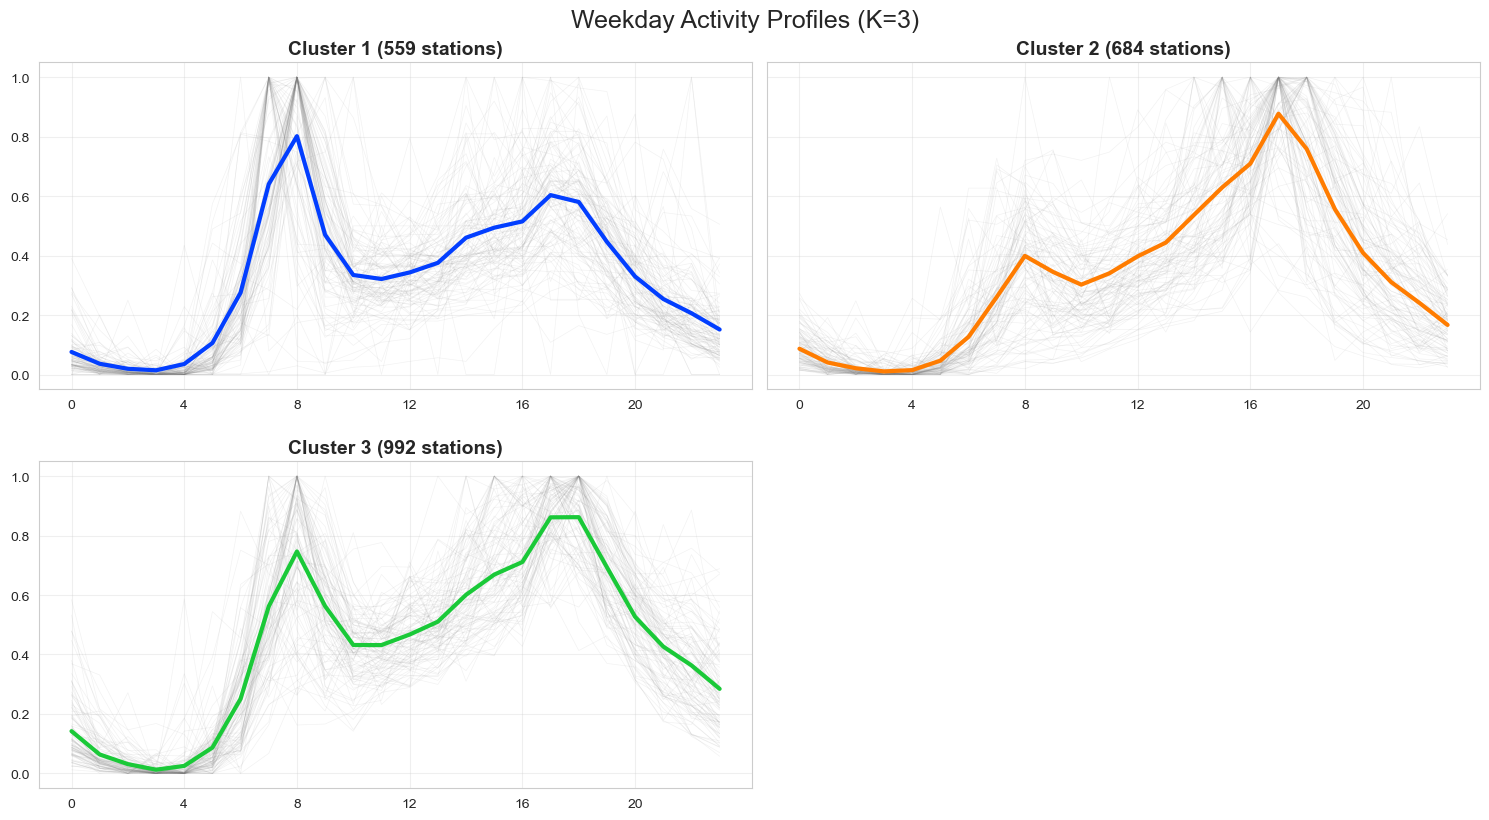

In [14]:
# Plot profiles for 3 clusters (General)
plot_cluster_profiles(df_signatures_weekday, 3, 'cluster_macro')

Esta primera división de 3 clusters parece bastante acertada. El primer lugar está el cluster 1, el cual tiene un pico muy alto de salidas a las 8 de la mañana y posteriormente se mantiene más o menos plano el resto del día. Ese primer cluster parece que muestra las estaciones residenciales, ya que son las estaciones que se utilizan para ir al trabajo.

Lo contrario pasa con el cluster 2, hay un pico enorme a las 17h, lo que señala que es un cluster de oficinas/trabajo, ya que un pico a esa hora representa el momento en el que los usuarios salen de trabajar y utilizan este medio de transporte para volver a casa o acercarse a alguna estación de transporte público que se encuentra alejada de su puesto de trabajo.

Por último estaría el cluster 3, el cual correspondería a zonas mixtas. Por un lado se encuentran los picos de los dos anteriores, a las 8h y 17h, además de mantenerse este segundo pico hasta las 18h, lo que puede significar que también está recogiendo las estaciones relacionadas con el ocio.

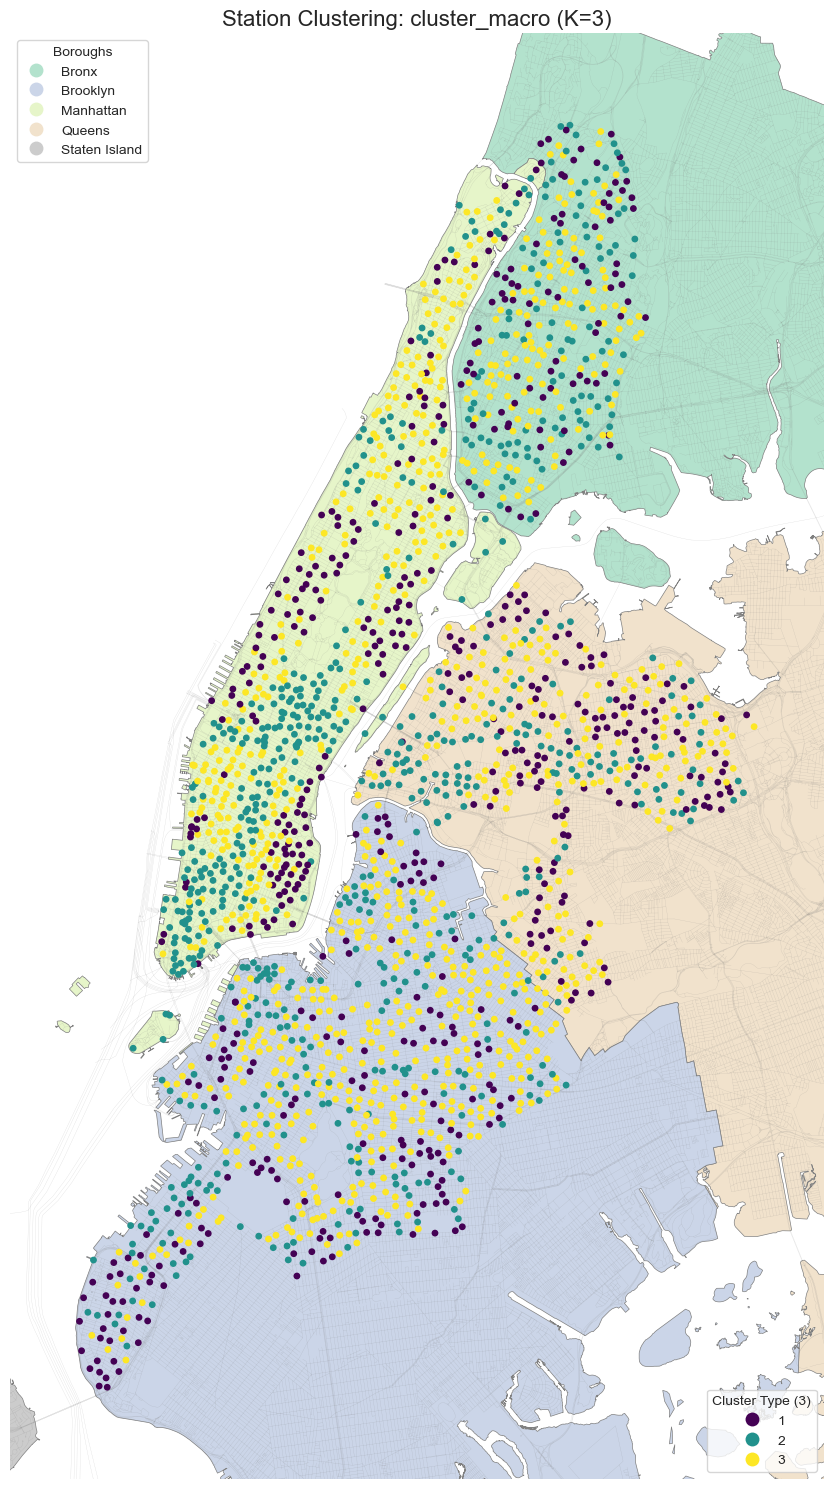

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

nyc_map.plot(
    ax=ax, 
    column='boroname',
    cmap='Pastel2',
    edgecolor='gray',
    linewidth=0.5,
    legend=True,
    legend_kwds={'loc': 'upper left', 'title': 'Boroughs'}
)

# Save the legend object to reuse later
leg1 = ax.get_legend()

nyc_streets.plot(
    ax=ax, 
    color='gray', 
    linewidth=0.2, 
    alpha=0.3,
    zorder=1
)

gdf_stations.plot(
    ax=ax, 
    column=CLUSTER_COLUMN_MACRO,
    cmap='viridis',
    markersize=15,
    alpha=1,
    legend=True,
    categorical=True,
    zorder=2,
    legend_kwds={'loc': 'lower right', 'title': 'Cluster Type'}
)

# Re-add the first legend (Boroughs)
ax.add_artist(leg1)

plt.title(f'Station Clustering: {CLUSTER_COLUMN_MACRO} (K={NUM_CLUSTERS_MACRO})', fontsize=16)
plt.axis('off')

minx, miny, maxx, maxy = gdf_stations.total_bounds
margin = 0.02
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)

plt.tight_layout()
plt.show()

Con el mapa visual de las estaciones con el cluster al que pertenece se pueden llegar a algunas conclusiones. Por un lado el cluster 1, correspondiente al análisis inicial con estaciones residenciales se aprecian especialmente en los barrios alrededor de Manhattan, lo cual tiene sentido ya que son barrios más económicos y son zonas que al estar tan alejadas de Manhattan quizá no tengan buenas comunicaciones, por lo tanto sería necesario que utilizaran este medio de transporte. Igualmente dentro de Manhattan se encuentran zonas como el Lower East Side, el Upper West Side  el Upper East Side los cuales son muy residenciales y tienen estaciones de este estilo.

El cluster 2, denominado inicialmente como cluster de trabajo/oficina se encuentra en todo el mapa. Cabe destacar la gran línea de estaciones que van desde el sur de Central Park bajando por el Midtown y terminando en el Financial District, los cuales aprueban la decisión de denominar a este cluster como de trabajo puesto que son zonas altamente densas en oficinas. Sin embargo, se puede apreciar que este cluster absorve también las estaciones de ocio. Esto se puede ver claramente en las pequeñas islas: Randalls Island y Governors Island o en la zona de DUMBO en Brooklyn las cuales son zonas principalmente de ocio, por lo que su uso se realizaría por la tarde y por lo tanto se considera como si fuera un lugar de trabajo.

Por últmo el cluster 3 era un cluster de estaciones que se situan en zonas donde existen tanto alta densidad de población como tiendas y demás opciones de ocio, es por ello que está repartido por todo el mapa de Nueva York. Hay una zona con especial concentración en el suroeste de Manhattan correspondiente al barrio de Chelsea el cual es conocido por ser un gran núcleo de población y por tener numerosas tiendas y restaurantes, lo cual apoya a la distinción de este cluster.

Tras este análisis visual se puede concluir que la diferenciación entre 3 clusters no es mala, sin embargo si que podría ser más precisa si se dividieran más los clusters.

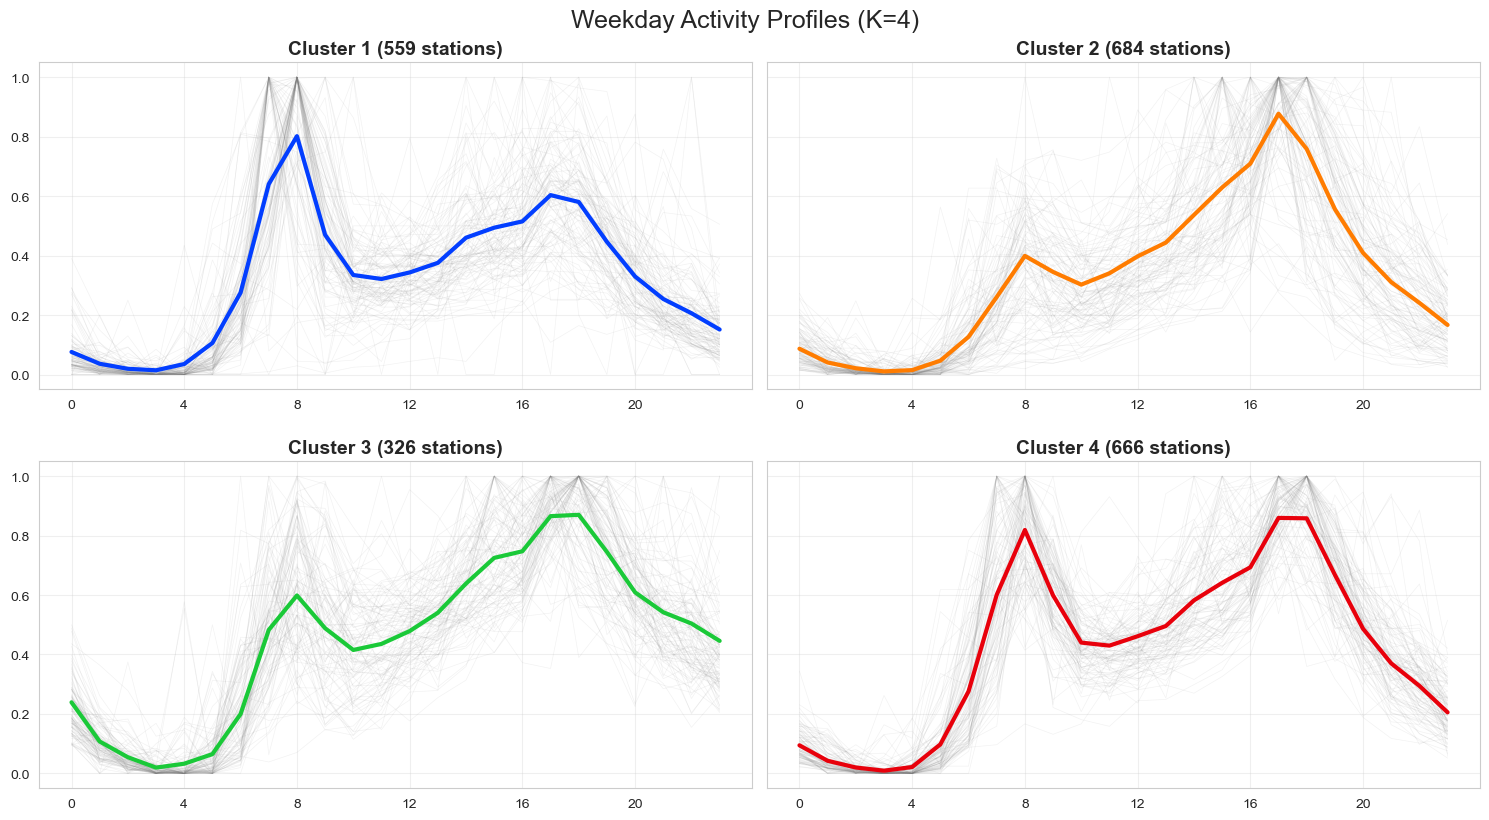

In [ ]:
# Plot profiles for 4 clusters (Balanced)
plot_cluster_profiles(df_signatures_weekday, 4, 'cluster_balanced')

La división en 4 clusters es similar a la anterior pero con matices importantes. Por un lado se sigue encontrando un cluster de oficinas/trabajo muy marcado, correspondiente al cluster 2. También, el cluster 1 corresponde a una zona residencial puesto que hay un pico muy grande a las 8h.

La principal diferencia viene dada en los clusters 3 y 4. En el 3, hay dos picos muy altos a las 17h y otro un poco más alto a las 18h, todo esto añadiendo un valor alto a las 8h. Esto supone que es una zona con gran afluencia de oficinas/lugares de trabajo puesto que hay un pico a la hora de salida, pero que también cuentan con zonas de ocio y algunas residenciales.
El cluster 4 tiene una particularidad que es que es una zona de gran densidad residencial, por el pico de salidas a las 8h, pero que también es una zona con grandes lugares de trabajo y ocio, por los picos a las 17h y 18h. Son puntos que quizá se encuentren al lado de parques u otras zonas de uso recreativo del servicio de bicicletas.

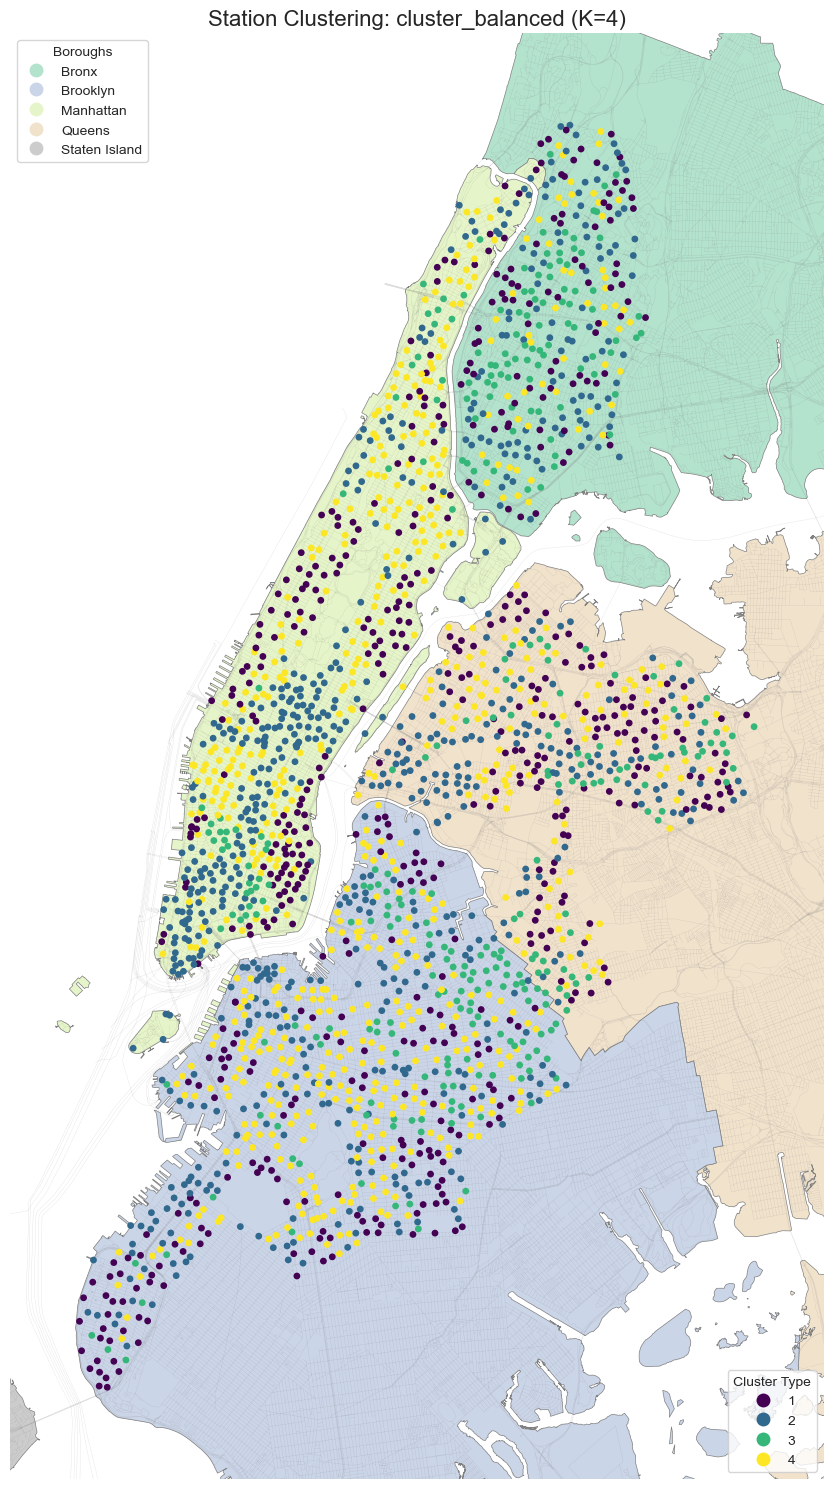

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))

nyc_map.plot(
    ax=ax, 
    column='boroname',
    cmap='Pastel2',
    edgecolor='gray',
    linewidth=0.5,
    legend=True,
    legend_kwds={'loc': 'upper left', 'title': 'Boroughs'}
)

# Save the legend object to reuse later
leg1 = ax.get_legend()

nyc_streets.plot(
    ax=ax, 
    color='gray', 
    linewidth=0.2, 
    alpha=0.3,
    zorder=1
)

gdf_stations.plot(
    ax=ax, 
    column=CLUSTER_COLUMN_BALANCED,
    cmap='viridis',
    markersize=15,
    alpha=1,
    legend=True,
    categorical=True,
    zorder=2,
    legend_kwds={'loc': 'lower right', 'title': 'Cluster Type'}
)

# Re-add the first legend (Boroughs)
ax.add_artist(leg1)

plt.title(f'Station Clustering: {CLUSTER_COLUMN_BALANCED} (K={NUM_CLUSTERS_BALANCED})', fontsize=16)
plt.axis('off')

minx, miny, maxx, maxy = gdf_stations.total_bounds
margin = 0.02
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)

plt.tight_layout()
plt.show()

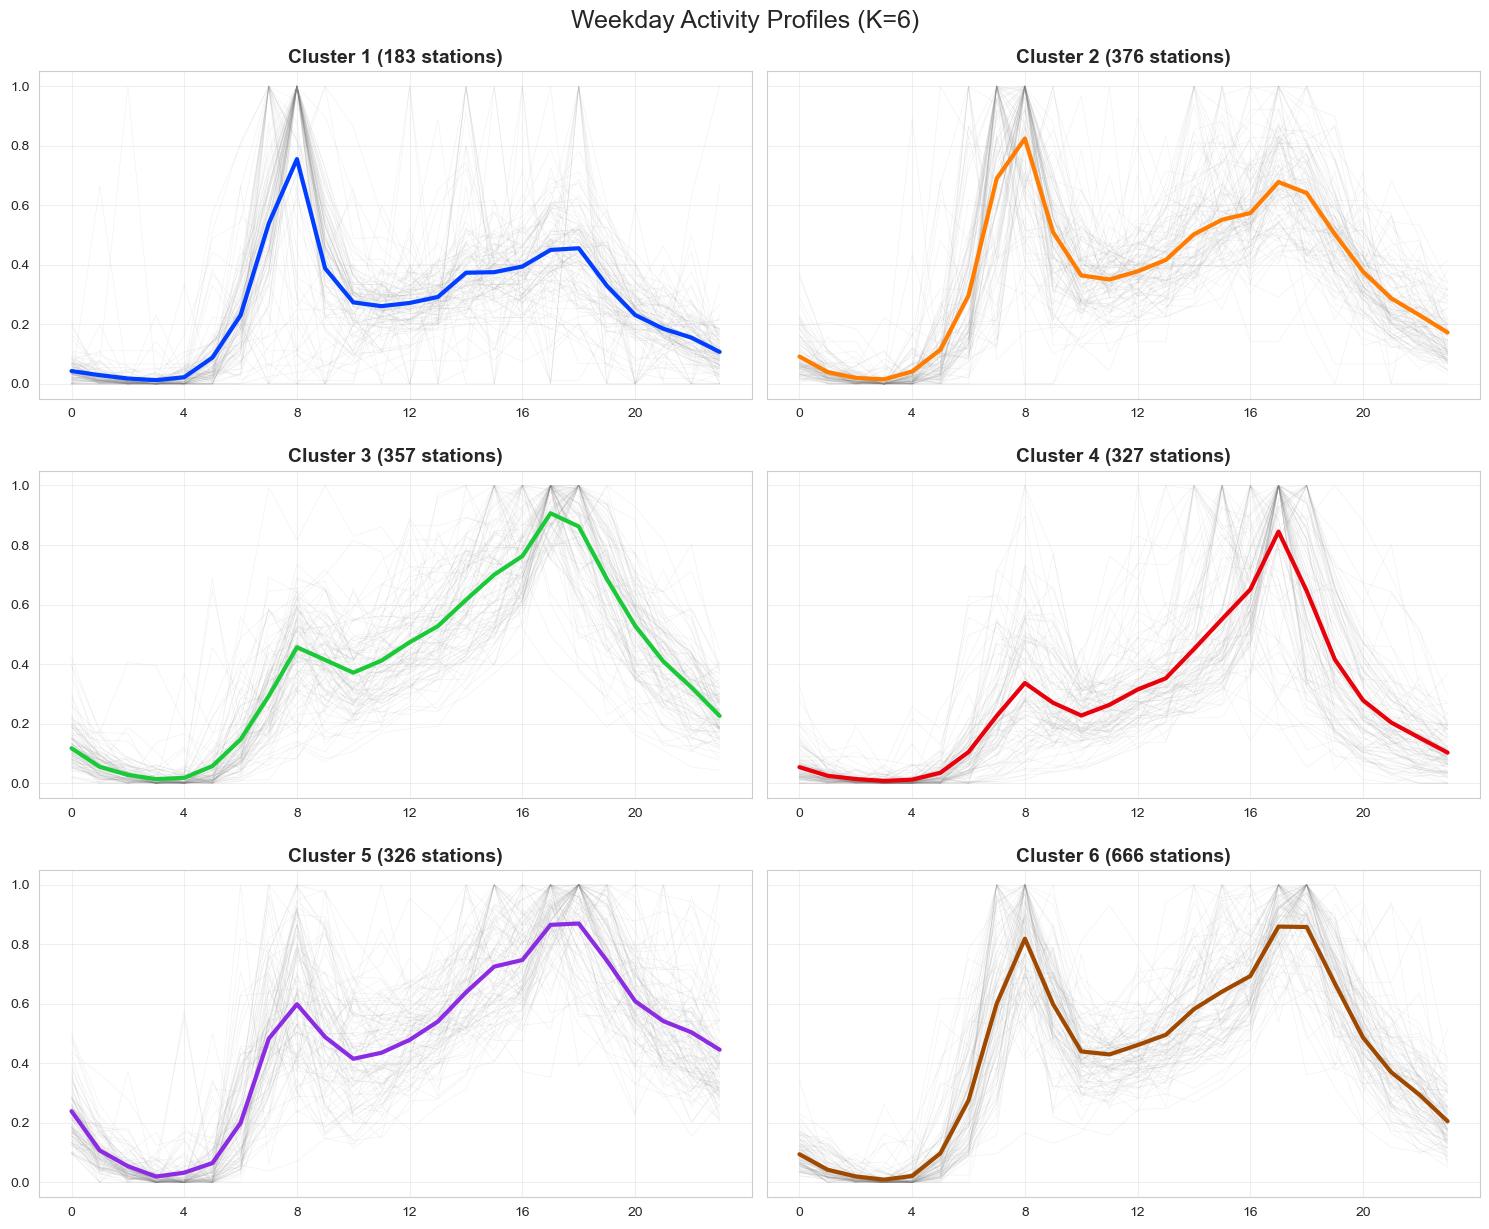

In [ ]:
# Plot profiles for 6 clusters (Especific)
plot_cluster_profiles(df_signatures_weekday, 6, 'cluster_micro')

Por último, con 6 clusters. Aquí las zonas están aún más fragmentadas por lo que es complicado concluir de qué tipo se tratan sin visualizar las estaciones en un mapa.

Por un lado, el cluster 1 parece que se trata de una zona de alta densidad residencial por el pico de salidas a las 8h y porterior mantenimiento de salidas a lo largo del día. Lo mismo pasa con el cluster 4 pero al contrario. Es una zona de alta densidad de oficinas/trabajo por el escaso número de salidas durante todo el día menos por el pico a las 17h.

El cluster 2, por su lado, parece una zona residencial en la periferia. Esto se debe a que el pico de salidas, además de a las 8h, también ocurre a las 7h. Esto puede ser porque trabajen en el centro y por lo tanto necesiten más tiempo para ir a trabajar.

Los clusters 3 y 5 son bastante similares en el sentido que son zonas con alto nivel residencial pero que también cuentan con picos muy altos al final de la tarde, lo que puede indicar que también hay muchos puestos de trabajo en esa zona.

Por último el cluster 6 parece ser una zona de alta densidad residencial que además está cerca de puntos donde utilizar la bicicleta en forma de ocio.

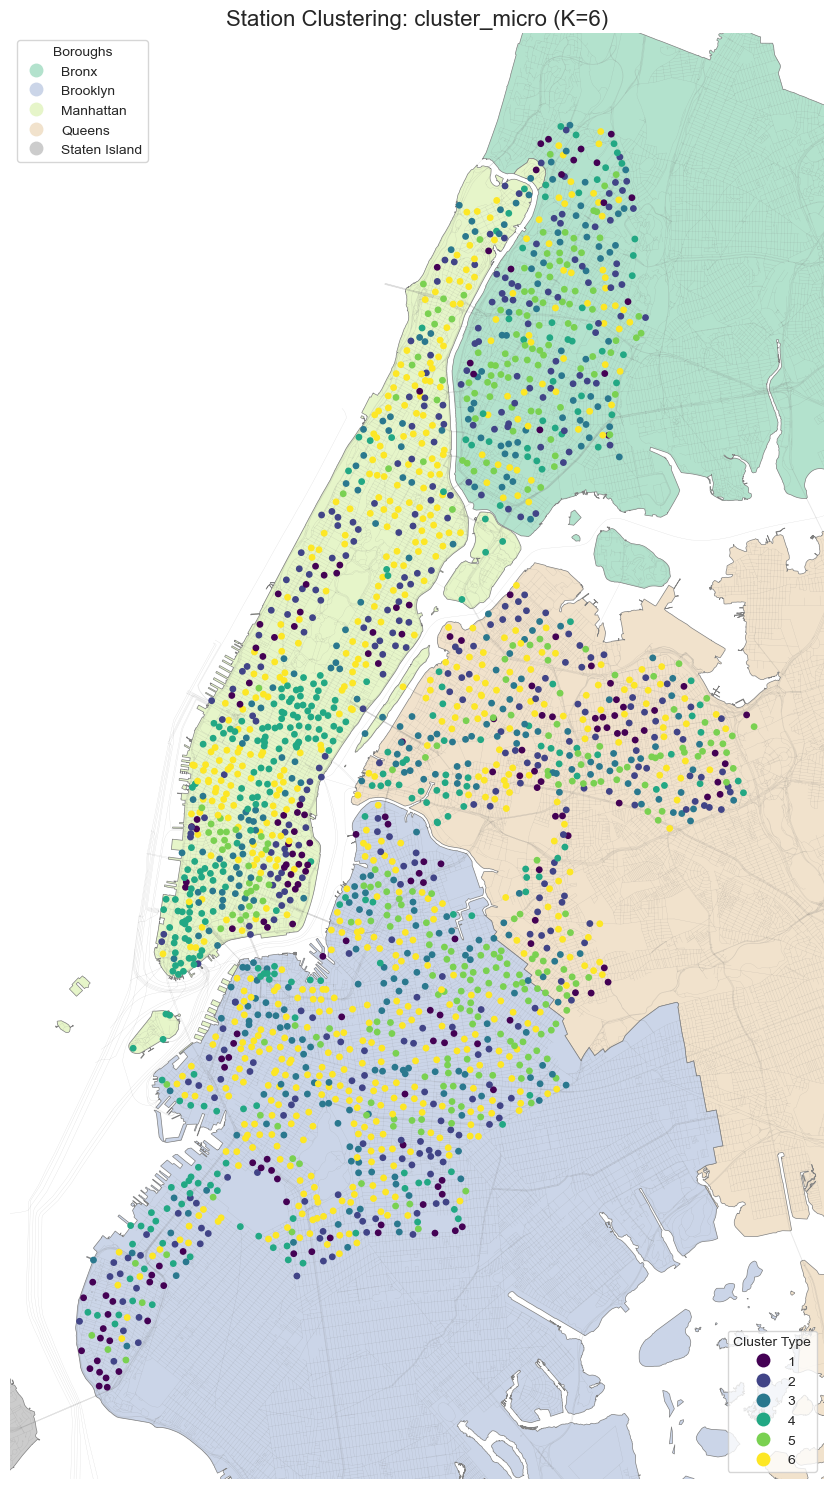

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))

nyc_map.plot(
    ax=ax, 
    column='boroname',
    cmap='Pastel2',
    edgecolor='gray',
    linewidth=0.5,
    legend=True,
    legend_kwds={'loc': 'upper left', 'title': 'Boroughs'}
)

# Save the legend object to reuse later
leg1 = ax.get_legend()

nyc_streets.plot(
    ax=ax, 
    color='gray', 
    linewidth=0.2, 
    alpha=0.3,
    zorder=1
)

gdf_stations.plot(
    ax=ax, 
    column=CLUSTER_COLUMN_MICRO,
    cmap='viridis',
    markersize=15,
    alpha=1,
    legend=True,
    categorical=True,
    zorder=2,
    legend_kwds={'loc': 'lower right', 'title': 'Cluster Type'}
)

# Re-add the first legend (Boroughs)
ax.add_artist(leg1)

plt.title(f'Station Clustering: {CLUSTER_COLUMN_MICRO} (K={NUM_CLUSTERS_MICRO})', fontsize=16)
plt.axis('off')

minx, miny, maxx, maxy = gdf_stations.total_bounds
margin = 0.02
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)

plt.tight_layout()
plt.show()